<a href="https://colab.research.google.com/github/r0bmar/cits4404project/blob/master/StockTradingColabNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Doing pairs trading using actor-critic reinforcement learning

## Description of task and setting up

### Importing libraries
In order to do reinforcement learning, an environment must be specified. Through the use of training, the model learns rules of the environment, and develops a strategy in order to achieve a goal. Our choice was to implement the environment using ```gym```. This library is standard for RL models and allows for seamless integration with a TensorFlow ```keras``` model implementation.

In [0]:
# associated libraries
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from enum import Enum

#for the trading environment
import gym
from gym import error, spaces, utils
from gym.utils import seeding

#for the models
import tensorflow as tf
import tensorflow.keras.layers as kl
import keras.backend as K
import tensorflow.keras.losses as kls

Using TensorFlow backend.


In [0]:
print(tf.__version__) # this is the version of TensorFlow that is being used

1.14.0


### Mount Google Drive

This cell mounts your personal Google Drive. In order to get the data to show up, the following steps must be taken:

* Go to your personal Google drive. You should see the "Pairs Trading Project" folder in the "Shared with me" section of your drive. Right click and click "Add to My Drive". This is done because Colab can only mount your personal Google Drive (i.e. there is no way to mount a shared Drive). However if a shared folder is added to your Drive, Colab can see it.
* Run this cell. To confirm this works, go to Files > Refresh, you should see the Pairs Trading Project folder under "content/drive/".

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Setting up the ```gym```

### Traversing the data in order to build up the data used to train on

In order to perform learning, a dataset must be specified. In our case, the data are CSV files of per-day stock prices. These are parsed in the ```DataSource``` class and standard functions are written in order to calculate changes in stock price over a day. This is the format of the data that will be used as input.

In [0]:
class DataSource(object):
    def __init__(self, data1, data2):
        self.d1 = pd.read_csv(data1)
        self.d2 = pd.read_csv(data2)

        self.d1 = self._prep_dataframe(self.d1)
        self.d2 = self._prep_dataframe(self.d2)

        self.trading_day = 0

        self.starting_date = max(min(self.d1['Date']), min(self.d2['Date'])) # highest start date
        self.end_date      = min(max(self.d1['Date']), max(self.d2['Date'])) # lowest end date

        self._trading_days = (self.end_date-self.starting_date).days

    def __iter__(self):
        self.trading_day = 0
        return self

    def __next__(self):
        while self.trading_day != self._trading_days:
            date = self.starting_date+timedelta(days=self.trading_day)
            self.trading_day += 1

            _s1 = self.d1[self.d1['Date']==date]
            _s2 = self.d2[self.d2['Date']==date]

            if _s1.shape[0] != 1: continue
            if _s2.shape[0] != 1: continue

            s1 = _s1.iloc[0]
            s2 = _s2.iloc[0]

            # Calculate percentage change in stock price
            s1_percent_change = (s1.Close - s1.Open) / s1.Open
            s2_percent_change = (s2.Close - s2.Open) / s2.Open

            return (date, np.array([s1.Close, s2.Close, s1_percent_change, s2_percent_change], dtype=np.float))
        raise StopIteration

    def _prep_dataframe(self, df):
        df['Date'] = pd.to_datetime(df['Date'])

        df = df[['Date','Open', 'Close']]
        return df

    def reset(self):
        self.trading_day = 0

### Load in data

In [0]:
data_1_path = "/content/drive/My Drive/Pairs Trading Project/data/Yahoo/AAPL.csv"
data_2_path = "/content/drive/My Drive/Pairs Trading Project/data/Yahoo/EOD-HD.csv"
ds = DataSource(data_1_path, data_2_path)

### Data cleaning

In [0]:
df = pd.DataFrame(columns=["Date", "S1 Close", "S2 Close", "S1 Change", "S2 Change"])
for date, data in ds:
    df = df.append({
     "Date": date,
     "S1 Close":  data[0],
     "S2 Close":  data[1],
     "S1 Change":  data[2],
     "S2 Change":  data[3],
      }, ignore_index=True)
    
df.head()
ds.reset()

### Plot of data

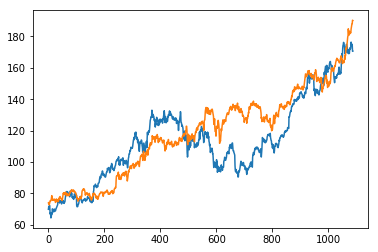

In [0]:
S1_price = df["S1 Close"]
S2_price = df["S2 Close"]
plt.plot(range(0, len(S1_price)), S1_price)
plt.plot(range(0, len(S2_price)), S2_price)

### Detrending data

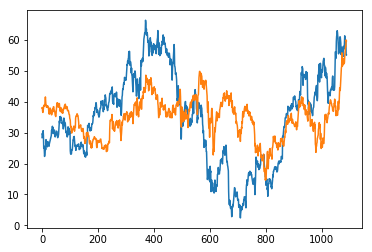

In [0]:
s1_detrend = signal.detrend(S1_price) + 35.
s2_detrend = signal.detrend(S2_price) + 35.

plt.plot(range(0, len(S1_price)), s1_detrend)
plt.plot(range(0, len(S2_price)), s2_detrend)

### Calculating spreads and updating the market

In [0]:
class MarketMetrics(object):
    def __init__(self, window_size=20):
        self._window_size = window_size

        self.window_1 = np.zeros(self._window_size)
        self.window_2 = np.zeros(self._window_size)

        self._i = 0

    def reset(self):
        self.window_1 = np.zeros(self._window_size)
        self.window_2 = np.zeros(self._window_size)

        self._i = 0

    def update(self, stock_price_1, stock_price_2):
        index = self._i % self._window_size
        
        self.window_1[index] = stock_price_1
        self.window_2[index] = stock_price_2

        max_stock_1 = max(self.window_1)
        max_stock_2 = max(self.window_2)

        self._i += 1

        data_ready = self._i >= self._window_size
        if not data_ready:
            return 0, False
        else:
            normalised_log_stock_1 = np.log(self.window_1 / max_stock_1)
            normalised_log_stock_2 = np.log(self.window_2 / max_stock_2)
            
            spread = normalised_log_stock_1[index] - normalised_log_stock_2[index]

            return spread, True

### Defining the action space

An environment must have an *action space*. The action space is a set of actions that can be taken at one particular time. In the case of pairs trading, there are three actions that can be taken. One can either buy into the spread, sell, or hold. It must be defined how the actions affect the underlying environment.

In [0]:
class Status(Enum):
    INVESTED_IN_SPREAD = 1
    OUT_OF_SPREAD = 2

class Actions(Enum):
    BUY = 0
    SELL = 1
    HOLD = 2

class TradingSim(object):
    def __init__(self, start_balance=10000, transaction_fee=10):
        self._start_balance = start_balance
        
        self.transaction_fee = transaction_fee
        self.balance = self._start_balance
        
        self.stock1_balance = 0
        self.stock2_balance = 0

        self.status = Status.OUT_OF_SPREAD
    
    def reset(self):
        self.balance = self._start_balance

        self.stock1_balance = 0
        self.stock2_balance = 0

        self.status = Status.OUT_OF_SPREAD

    def get_NAV(self, stock1_price, stock2_price):
        return self.balance + \
            self.stock1_balance * stock1_price + \
            self.stock2_balance * stock2_price

    def execute(self, action, spread, stock1_price, stock2_price):
        action = Actions(action)
        if action == Actions.BUY:
            if self.status == Status.INVESTED_IN_SPREAD:
                return # Cannot invest if already invested

            # Invest in spread
            if spread < 0:
                # buy stock 1
                self.balance, self.stock1_balance = self.buy(stock1_price)
            else:
                # buy stock 2
                self.balance, self.stock2_balance = self.buy(stock2_price)

            self.status = Status.INVESTED_IN_SPREAD
        elif action == Actions.SELL:
            if self.status == Status.OUT_OF_SPREAD:
                return # Cannot sell if not invested

            if self.stock1_balance > 0:
                # sell stock 1
                self.balance, self.stock1_balance = self.sell(stock1_price, self.stock1_balance)
            elif self.stock2_balance > 0:
                # sell stock 2
                self.balance, self.stock2_balance = self.sell(stock2_price, self.stock2_balance)

            self.status = Status.OUT_OF_SPREAD
        elif action == Actions.HOLD:
            return

    def buy(self, stock_price):
        """Calculates maximum amount of stock that can be bought with
        current cash balance. Returns the new cash and stock balance 
        values.
        
        Arguments:
            stock_price {int} -- Stock price
        Returns:
            (int, int) -- Tuple of new cash balance, and new stock balance
        """

        available_cash_to_spend = self.balance - self.transaction_fee

        max_stocks_to_buy = available_cash_to_spend // stock_price

        new_cash_balance = self.balance - \
            (max_stocks_to_buy * stock_price) - \
            self.transaction_fee

        return (new_cash_balance, max_stocks_to_buy)

    def sell(self, stock_price, stock_balance):
        """Calculates cash balance that is returned when a stock is 
        sold. Returns the new cash and stock balance 
        values.
        
        Arguments:
            stock_price {int} -- Stock price
            stock_balance {int} -- Current stock balance
        Returns:
            (int, int) -- Tuple of new cash balance, and new stock balance
        """

        stock_value = stock_balance * stock_price

        new_cash_balance = self.balance + \
            stock_value - \
            self.transaction_fee

        return (new_cash_balance, 0)

### Creating the environment

In [0]:
class PairsTradingEnv(gym.Env):
    metadata = {'render.modes': ['human', 'console']}

    action_space = spaces.Discrete(3)
    observation_space = spaces.Box(
        low=-1,
        high=1,
        shape=(3,)
    )

    def __init__(self, data_1, data_2):
        super(PairsTradingEnv, self).__init__()
        self.data_source = DataSource(data_1, data_2)
        self.trading_sim = TradingSim()
        self.market_metrics = MarketMetrics()

        self.trading_day = 0

        self.render_data = {'buy': [], 'sell': [], 'hold': [], 'portfolio_value': [], 'spread': []}
        self.plot_data = {}

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.data_source.reset()
        self.trading_sim.reset()
        self.market_metrics.reset()

        self.trading_day = 1

        self.render_data = {'buy': [], 'sell': [], 'hold': [], 'portfolio_value': [], 'spread': []}
        self.plot_data = {}

        date, data = next(self.data_source)
        s1_price, s2_price, s1_pct, s2_pct = data

        spread, data_ready = self.market_metrics.update(s1_price, s2_price)
        while not data_ready:
            date, data = next(self.data_source)
            s1_price, s2_price, s1_pct, s2_pct = data

            spread, data_ready = self.market_metrics.update(s1_price, s2_price)
            self.trading_day += 1


        return np.array([s1_pct, s2_pct, spread])

    def step(self, action):
        done = 0 
        try:
            date, data = next(self.data_source)
        except StopIteration:
            done = 1
            obs = [0, 0, 0]
            reward = 0
            return obs, reward, done, {}
        s1_price, s2_price, s1_pct, s2_pct = data

        spread, _ = self.market_metrics.update(s1_price, s2_price)

        self.trading_sim.execute(action, spread, s1_price, s2_price)

        self.trading_day += 1

        obs = np.array([s1_pct, s2_pct, spread])
        reward = self.trading_sim.get_NAV(s1_price, s2_price)

        if action == 0:
            self.render_data['buy'].append((self.trading_day, reward))
        elif action == 1:
            self.render_data['sell'].append((self.trading_day, reward))
        else:
            self.render_data['hold'].append((self.trading_day, reward))
        self.render_data['portfolio_value'].append((self.trading_day, reward))
        self.render_data['spread'].append((self.trading_day, spread))

        return obs, reward, done, {"date": date, "trading_day": self.trading_day}

    def render(self, mode='human'):
        if mode=='human':
            # Setting up matplotlib data structures
            fig = self.plot_data.get('portfolio_value_fig') or plt.figure(figsize=(18, 4.5))
            ax  = self.plot_data.get('portfolio_value_ax') or fig.add_subplot(121)
            ax2  = self.plot_data.get('portfolio_value_ax2') or fig.add_subplot(122)

            self.plot_data['portfolio_value_fig'] = fig
            self.plot_data['portfolio_value_ax'] = ax
            self.plot_data['portfolio_value_ax2'] = ax2

            fig.suptitle("Pairs Trading with Machine Learning")

            # Separate x and y data from lists of tuples
            x_data = lambda data: [x[0] for x in data]
            y_data = lambda data: [x[1] for x in data]

            # Plot Portfolio values
            ax.clear()
            ax.set_title('Portfolio Value')
            ax.plot(
                x_data(self.render_data['portfolio_value']),
                y_data(self.render_data['portfolio_value']),
                label='Portfolio value'
            )

            # Plot Actions data
            ax.plot(x_data(self.render_data['buy']), y_data(self.render_data['buy']), '.r', label='Buy')
            ax.plot(x_data(self.render_data['sell']), y_data(self.render_data['sell']), '^g', label='Sell')
            ax.plot(x_data(self.render_data['hold']), y_data(self.render_data['hold']), 'xy', label='Hold')
            ax.legend(loc='best')

            # Plot spread
            ax2.clear()
            ax2.set_title('Stock Price Spread')
            ax2.plot(
                x_data(self.render_data['spread']),
                y_data(self.render_data['spread']),
                color='#9467bd'
            )

            fig.canvas.draw()
            fig.canvas.flush_events()
            plt.pause(0.05)
        elif mode=='console':
            latest_data = self.render_data # [-1]

            trading_day, nav, _, spread = latest_data

            print(f"Trading day: {trading_day}. Portfolio Value: {nav}. Spread: {spread}")
        else:
            print("Invalid render mode")

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Setting up the reinforcement learning models

In [0]:
from keras.models import Sequential, Model
class ActorCritic(object):
    """ActorCritic model for continous observation space, and discrete action space
    
    Arguments:
        object {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    def __init__(self, env, **kwargs):
        self.env=env

        self.learning_rate = kwargs.get('learning_rate', 0.001)
        self.gamma = kwargs.get('gamma', 0.99)
    
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []
        
        self.actor_model  = self._create_actor_model()
        self.critic_model = self._create_critic_model()

    def _create_actor_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(self.env.action_space.n, activation='softmax', name='policy_logits')
        ])
        model.compile(loss=self._actor_loss(), optimizer='adam')
        return model

    def _create_critic_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(1, activation='relu')
        ])
        model.compile(loss="mse", optimizer='adam')

        return model

    def _actor_loss(self):
        def loss(y_true,y_pred):
            weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
            actions = tf.cast(y_true[:,1], tf.int32)
            loss = weighted_sparse_ce(actions, y_pred, sample_weight = y_true[:,0])
            print(loss)
            return loss    
        return loss

    def _critic_loss(self):
        def loss(y_true,y_pred):
            return K.mean(K.square(y_pred - y_true), axis=-1)
        
        return loss

    def train(self, obs_history):
        advantages = np.array(self.rewards) - np.array(self.saved_values)
        #take negative since we want to minimize LOSS
        #action_loss = -1*advantages*np.array(self.saved_actions)
        y_label = []
        for adv, action in zip(advantages, np.array(self.saved_actions)):
            y_label.append([adv,action,0])
        
        y_label = np.array(y_label)
        self.actor_model.train_on_batch(np.array(obs_history), y_label)
        self.critic_model.train_on_batch(np.array(obs_history), self.rewards)
    
    def eval_state(self, obs):
        return self.critic_model.predict(obs[None, :])
    
    def predict_action(self, obs):
        logits = self.actor_model.predict(obs[None, :])
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
        return logits[0]
    
    def predict(self,obs):
        return self.eval_state(obs), self.predict_action(obs)
    
    def reset(self):
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []

## Implementing the environment and models to perform pairs trading



In [0]:
env = PairsTradingEnv(
     "/content/drive/My Drive/Pairs Trading Project/data/Yahoo/AAPL.csv",
     "/content/drive/My Drive/Pairs Trading Project/data/Yahoo/AAPL.csv"
)
model = ActorCritic(env)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("loss/policy_logits_loss/SparseCategoricalCrossentropy/weighted_loss/value:0", shape=(), dtype=float32)


Episode0


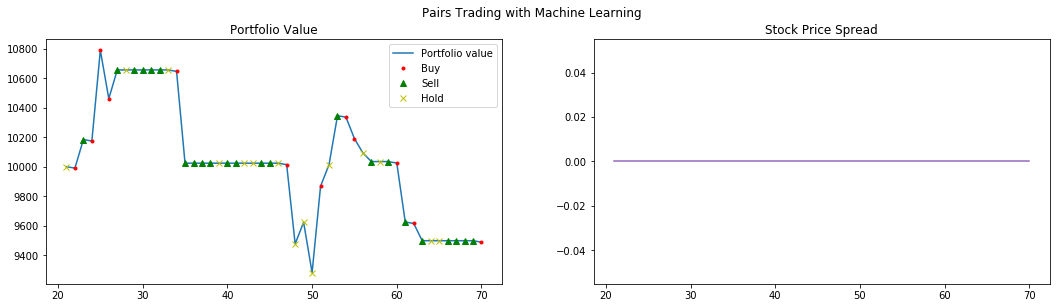

Episode1


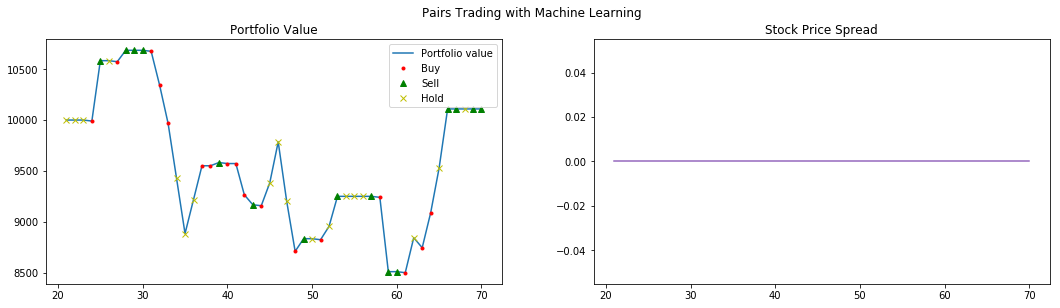

Episode2


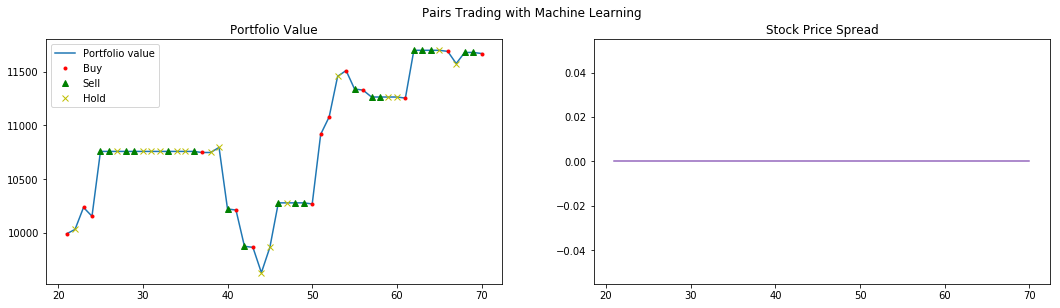

Episode3


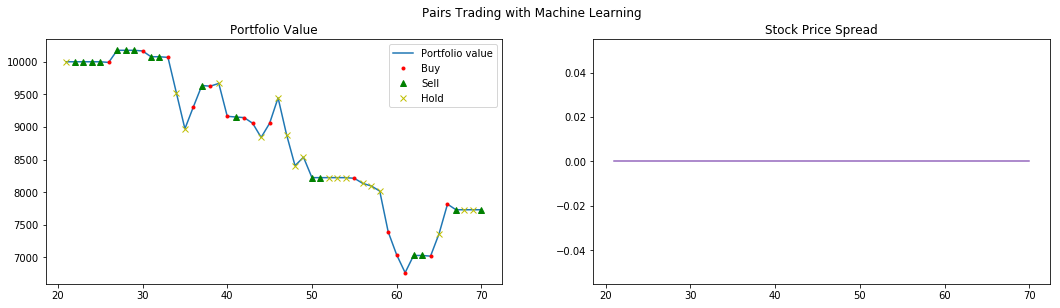

Episode4


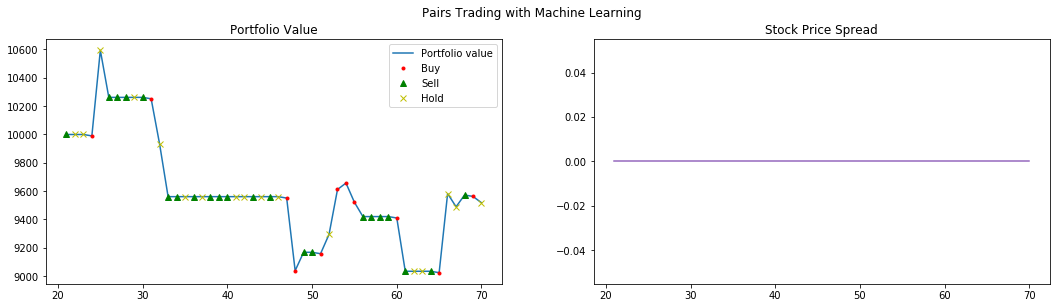

Episode5


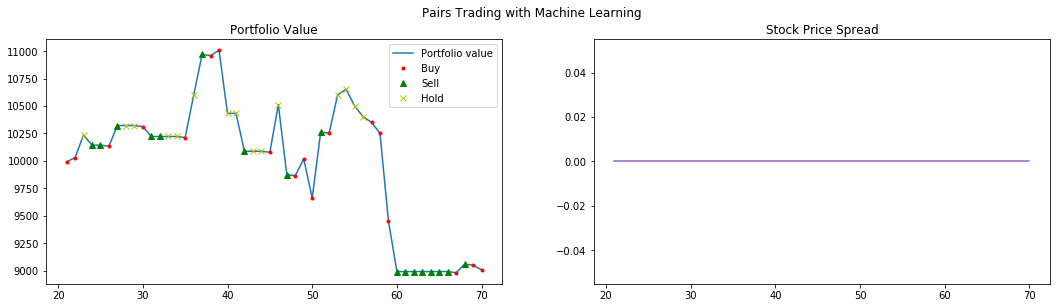

Episode6


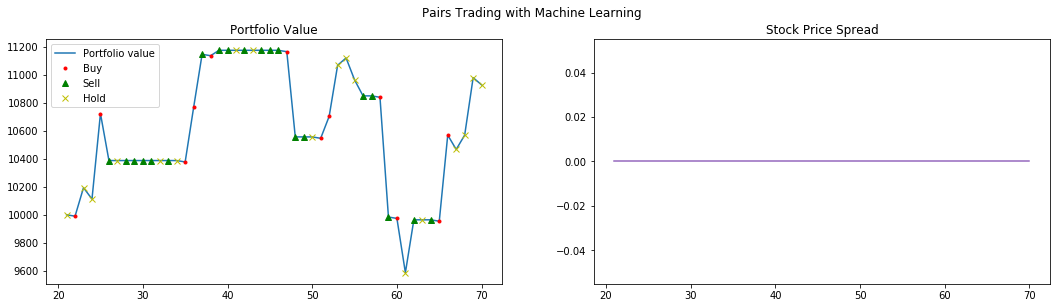

Episode7


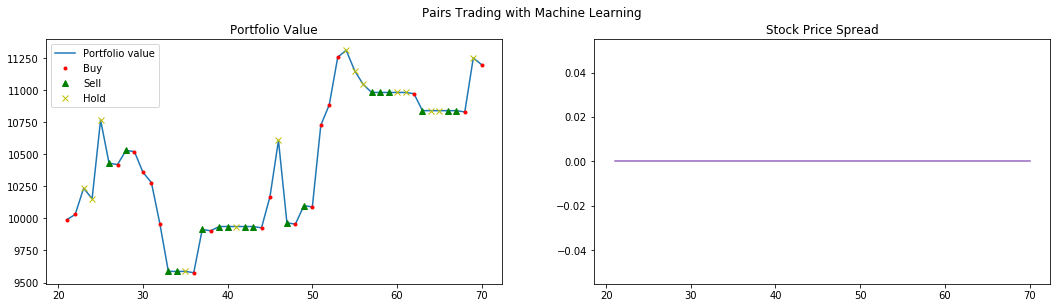

Episode8


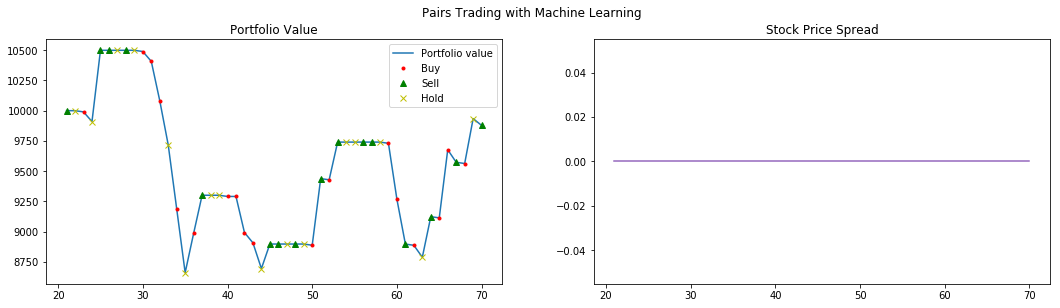

Episode9


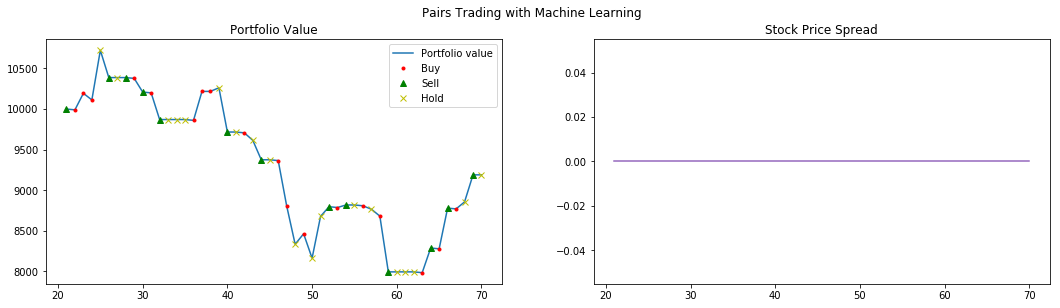

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    action_history = []

    obs = env.reset()
    
    running_reward = 0
    gamma = 0.99
    for episode in range(0, 10):
        print("Episode" + str(episode))
        obs = env.reset()
        obs_history = []
        model.reset()
        reward = 0
        done = False
        counter = 0
        while not done and counter < 50:
            state_value, actionProb = model.predict(obs)
            action = np.random.choice([0,1,2], p=actionProb)
            obs, reward, done, msg = env.step(action)
            
            obs_history.append(obs[None, :][0])
            model.saved_actions.append(action)
            model.saved_values.append(state_value[0][0])
            model.rewards.append(reward)
            if done:
                break
            counter+=1
        model.train(obs_history)
        env.render()
        